In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# importing the important libraries

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

# importing the libraries for deep learning model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.utils import pad_sequences
# from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# reading the data

train = pd.read_csv('drive/MyDrive/Web Search/drugsComTrain_raw.csv')
test = pd.read_csv('drive/MyDrive/Web Search/drugsComTest_raw.csv')

# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [ ]:
#  Previewing the train dataset
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
# Previewing the test dataset
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [ ]:
# Combining the two datasets for data exploration
data = pd.concat([train, test])

In [ ]:
df_condition_train = train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition_train = pd.DataFrame(df_condition_train).reset_index()
df_condition_train.tail()

,condition,drugName
879,Sepsis,1
880,72</span> users found this comment helpful.,1
881,Microscopic polyangiitis,1
882,Short Stature,1
883,"Epicondylitis, Tennis Elbow",1


In [ ]:
df_condition_test = test.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition_test = pd.DataFrame(df_condition_test).reset_index()
df_condition_test.tail()

,condition,drugName
703,Cyclitis,1
704,Intraabdominal Infection,1
705,Renal Tubular Acidosis,1
706,Allergic Urticaria,1
707,Pain/Feve,1


# Light GBM

### Data Preprocessing

In [ ]:
def data_preprocessing(data):

  # Creating a new column for initial sentiment classification
  data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
  data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

  # converting the date into datetime format
  data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

  # now extracting year, month and day from date
  data['Year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['day'] = data['date'].dt.day

  # we will delete the rows so that the data does not overfits
  data = data.dropna(axis = 0)
  data = data.reset_index()

  # removing the conditions with <span> in it
  all_list = set(data.index)
  span_list = []
  for i,j in enumerate(data['condition']):
      if '</span>' in j:
          span_list.append(i)
  new_idx = all_list.difference(set(span_list))
  data = data.iloc[list(new_idx)].reset_index()
  del data['index']

  return data

In [ ]:
df_train = data_preprocessing(train)
df_test = data_preprocessing(test)

In [ ]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
# setting a df with conditions with only one drug
df_condition_train_1 = df_condition_train[df_condition_train['drugName'] == 1].reset_index()

all_list = set(df_train.index)

# deleting them
condition_list = []
for i,j in enumerate(df_train['condition']):
    for c in list(df_condition_train_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
train_proc = df_train.iloc[list(new_idx)].reset_index()
del train_proc['index']

In [ ]:
# setting a df with conditions with only one drug
df_condition_test_1 = df_condition_test[df_condition_test['drugName'] == 1].reset_index()

all_list = set(df_test.index)

# deleting them
condition_list = []
for i,j in enumerate(df_test['condition']):
    for c in list(df_condition_test_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
test_proc = df_test.iloc[list(new_idx)].reset_index()
del test_proc['index']

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [ ]:
%time df_train['review_clean'] = df_train['review'].apply(review_to_words)

<ipython-input-54-c92ea89fce1d>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


CPU times: user 2min 10s, sys: 456 ms, total: 2min 11s
Wall time: 2min 19s


In [ ]:
%time df_test['review_clean'] = df_test['review'].apply(review_to_words)

<ipython-input-54-c92ea89fce1d>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


CPU times: user 44.3 s, sys: 198 ms, total: 44.5 s
Wall time: 45.5 s


In [ ]:
count_df1 = df_train[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df1.head()

,condition,review
92,Birth Control,28788
189,Depression,9069
521,Pain,6145
52,Anxiety,5904
7,Acne,5588


In [ ]:
count_df2 = df_test[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df2.head()

,condition,review
78,Birth Control,9648
157,Depression,3095
434,Pain,2100
43,Anxiety,1908
5,Acne,1847


In [ ]:
target_conditions1 = count_df1[count_df1['review']>1000]['condition'].values
target_conditions2 = count_df2[count_df2['review']>1000]['condition'].values

In [ ]:
def condition_parser1(x):
    if x in target_conditions1:
        return x
    else:
        return "OTHER"

df_train['condition'] = df_train['condition'].apply(lambda x: condition_parser1(x))

In [ ]:
def condition_parser2(x):
    if x in target_conditions2:
        return x
    else:
        return "OTHER"

df_test['condition'] = df_test['condition'].apply(lambda x: condition_parser2(x))

In [ ]:
df_train = df_train[df_train['condition']!='OTHER']
df_test = df_test[df_test['condition']!='OTHER']

### Feature Engineering and Modeling

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# #folds = KFold(n_splits=5, shuffle=True, random_state=546789)
# target = df_train['Review_Sentiment']
# feats = ['usefulCount']

# sub_preds = np.zeros(df_test.shape[0])

# trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42)
# feature_importance_df = pd.DataFrame()

# clf = LGBMClassifier(
#         n_estimators=2000,
#         learning_rate=0.05,
#         num_leaves=30,
#         #colsample_bytree=.9,
#         subsample=.9,
#         max_depth=7,
#         reg_alpha=.1,
#         reg_lambda=.1,
#         min_split_gain=.01,
#         min_child_weight=2,
#         silent=-1,
#         verbose=-1,
#         )

# clf.fit(trn_x, trn_y,
#         eval_set= [(trn_x, trn_y), (val_x, val_y)],
#         verbose=100, early_stopping_rounds=100  #30
#     )

# sub_preds = clf.predict(df_test[feats])

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
# FEATURE ENGINEERING

def feature_eng(data):
    # word count in each unclean comment
    data['count_sent'] = data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

    # Word count in each comment:
    data['count_word'] = data["review_clean"].apply(lambda x: len(str(x).split()))

    # Unique word count
    data['count_unique_word'] = data["review_clean"].apply(lambda x: len(set(str(x).split())))

    # Letter count
    data['count_letters'] = data["review_clean"].apply(lambda x: len(str(x)))

    # punctuation count
    import string
    data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    # upper case words count
    data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    # title case words count
    data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    # Number of stopwords
    data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

    # Average length of the words
    data["mean_word_len"] = data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

    # adding season
    data['season'] = data["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

    return data

In [ ]:
# lenght of train

len_train = df_train.shape[0]
print(len_train)

110121


In [ ]:
df_train = feature_eng(df_train)
df_test = feature_eng(df_test)

df_train.columns

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Index(['level_0', 'uniqueID', 'drugName', 'condition', 'review', 'rating',
       'date', 'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day',
       'review_clean', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len', 'season'],
      dtype='object')

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['Review_Sentiment']

feats = ['usefulCount','day','Year','month', 'count_sent',
          'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
          'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42)
feature_importance_df = pd.DataFrame()

clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(trn_x, trn_y,
        eval_set= [(trn_x, trn_y), (val_x, val_y)],
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[100]	training's binary_logloss: 0.479814	valid_1's binary_logloss: 0.500269
[200]	training's binary_logloss: 0.460267	valid_1's binary_logloss: 0.493613
[300]	training's binary_logloss: 0.442104	valid_1's binary_logloss: 0.48793
[400]	training's binary_logloss: 0.427051	valid_1's binary_logloss: 0.482836
[500]	training's binary_logloss: 0.412391	valid_1's binary_logloss: 0.477935
[600]	training's binary_logloss: 0.39814	valid_1's binary_logloss: 0.472942
[700]	training's binary_logloss: 0.386114	valid_1's binary_logloss: 0.46902
[800]	training's binary_logloss: 0.374439	valid_1's binary_logloss: 0.465154
[900]	training's binary_logloss: 0.362928	valid_1's binary_logloss: 0.461681
[1000]	training's binary_logloss: 0.35229	valid_1's binary_logloss: 0.457903
[1100]	training's binary_logloss: 0.341083	valid_1's binary_logloss: 0.454283
[1200]	training's binary_logloss: 0.332184	valid_1's binary_logloss: 0.451278
[1300]	training's binary_logloss: 0.322929	valid_1's binary_logloss: 0.448235

In [ ]:
import lightgbm

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

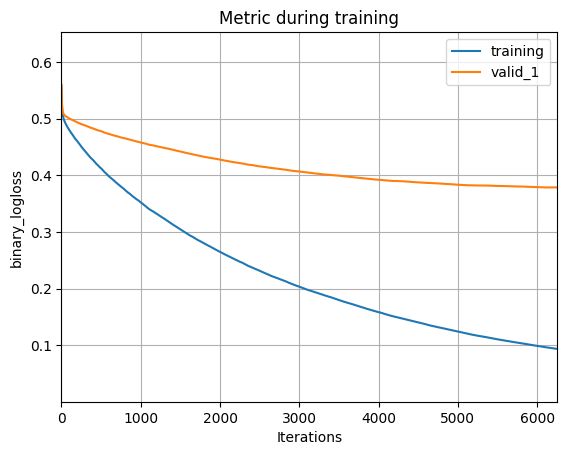

In [ ]:
lightgbm.plot_metric(clf)

In [ ]:
solution = df_test['Review_Sentiment']
df_test['Predicted_Sentiment'] = sub_preds

confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[ 4031,  2456],
       [  990, 17295]])

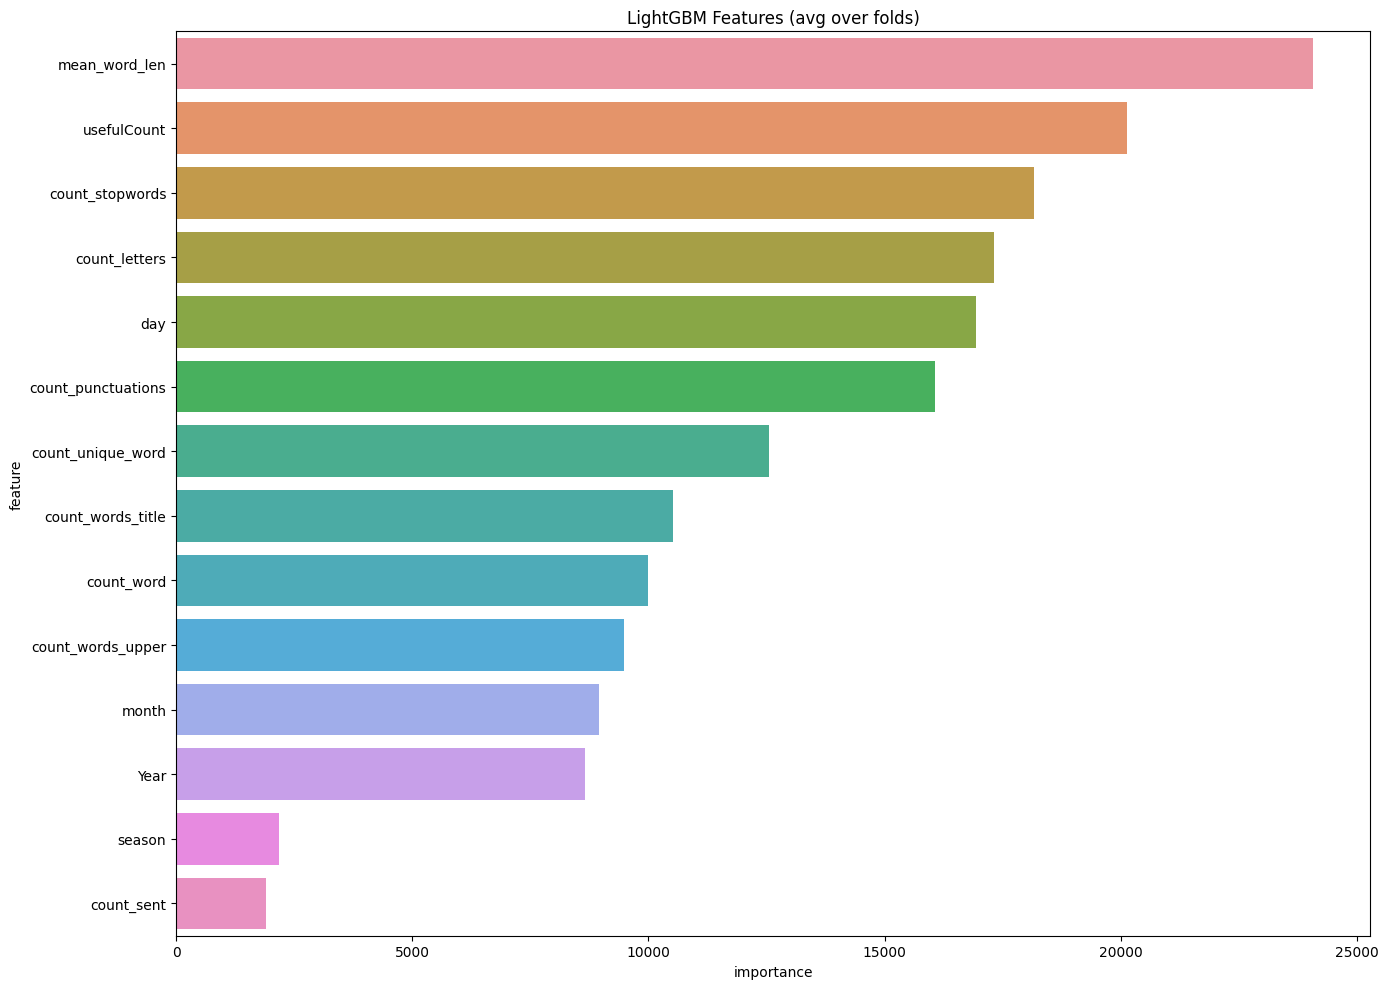

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending = False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
# Calculating the RMSE
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score

print('The rmse of prediction is:', round(mean_squared_log_error(sub_preds, solution) ** 0.5, 5))
print('The accuracy of prediction is:', (accuracy_score(sub_preds, solution)))

The rmse of prediction is: 0.25853
The accuracy of prediction is: 0.8608913289197481


# Rank Ordering the Best Drugs per Condition

In [ ]:
df_test.head()

,level_0,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,...,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,Predicted_Sentiment
0,0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,1.0,2012,...,37,34,255,22,2,4,26,5.918919,4,1.0
3,3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,1.0,2017,...,65,59,374,42,10,14,70,4.769231,1,1.0
4,4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,1.0,2015,...,66,55,386,17,10,17,77,4.863636,3,1.0
6,6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,2016-06-06,1,1.0,2016,...,47,37,281,34,3,4,44,5.000000,2,0.0
9,9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,2011-04-16,3,0.0,2011,...,43,42,241,13,5,9,45,4.627907,1,0.0


In [ ]:
df_filt = df_test[['drugName', 'condition', 'usefulCount', 'Predicted_Sentiment']]

In [ ]:
df_filt = df_filt.sort_values(by=['drugName', 'condition'])
df_filt.head()

,drugName,condition,usefulCount,Predicted_Sentiment
390,Abilify,Bipolar Disorde,10,1.0
1046,Abilify,Bipolar Disorde,38,0.0
3006,Abilify,Bipolar Disorde,12,1.0
4706,Abilify,Bipolar Disorde,4,0.0
5122,Abilify,Bipolar Disorde,46,1.0


In [ ]:
from sklearn import preprocessing
import numpy as np

pairs = []

for i in range(len(df_filt)):
  drug = df_filt.iloc[i, 0]
  cond = df_filt.iloc[i, 1]

  if (drug, cond) not in pairs:
    pairs.append((drug, cond))

In [ ]:
norm_values = []
for pair in pairs:
  drug = pair[0]
  cond = pair[1]

  counts = np.array(df_filt[(df_filt['drugName'] == drug) & (df_filt['condition'] == cond)]['usefulCount'])
  normalized_arr = preprocessing.normalize([counts])
  norm_values.append(normalized_arr)

In [ ]:
final_norm_values = []

In [ ]:
for arr in norm_values:
  for val in arr[0]:
    # print(val)
    final_norm_values.append(val)

In [ ]:
df_filt['Norm'] = final_norm_values

In [ ]:
df_filt['Adj_sent'] = df_filt['Predicted_Sentiment'] * df_filt['Norm']
rank_order = df_filt[['condition','drugName', 'Adj_sent']].groupby(['condition', 'drugName']).aggregate({'Adj_sent':'mean'}).reset_index().sort_values(['condition', 'drugName', 'Adj_sent'])
rank_order.head()

,condition,drugName,Adj_sent
0,ADHD,Adderall,0.092003
1,ADHD,Adderall XR,0.141356
2,ADHD,Adzenys XR-ODT,0.422036
3,ADHD,Amphetamine,0.210986
4,ADHD,Amphetamine / dextroamphetamine,0.067245


In [ ]:
from google.colab import files

rank_order.to_csv('output_baseline.csv', encoding = 'utf-8-sig')
files.download('output_baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rank_order[(rank_order['condition'] == 'Acne') & (rank_order['Adj_sent'] != 1.0)].sort_values(by=['Adj_sent'], ascending = False)

,condition,drugName,Adj_sent
72,Acne,Cephalexin,0.705887
48,Acne,Absorica,0.705024
110,Acne,Onexton,0.702782
91,Acne,Gildess Fe 1 / 20,0.683825
113,Acne,Retapamulin,0.670820
...,...,...,...
115,Acne,Salicylic acid,0.000000
86,Acne,Epiduo Forte,0.000000
99,Acne,Loestrin Fe 1 / 20,0.000000
97,Acne,Junel Fe 1.5 / 30,0.000000
